In [1]:
import sys 
sys.path.append('nngp')

import os.path

import numpy as np
import tensorflow as tf
print(tf.__version__)

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import load_model

from nngp.nngp import NNGPKernel
from nngp.gpr import GaussianProcessRegression

import matplotlib.pyplot as plt
%matplotlib inline

1.5.0


Using TensorFlow backend.


In [2]:
mnist = fetch_mldata('MNIST original', data_home='mnist')
mnist.DESCR

'mldata.org dataset: mnist-original'

In [3]:
lb = LabelBinarizer()
lb.fit(mnist.target)
# encode target labels as zero-mean one hot encoded vector 
# with negative class = -0.1 and positive class as 0.9
encode = lambda y: lb.transform(y) - .1

In [4]:
image_train, image_test, label_train, label_test = train_test_split(
    mnist.data, mnist.target, stratify = mnist.target, random_state = 444, test_size=.1)

X_test = image_test
y_test = encode(label_test)

In [5]:
def get_train_subset(n):
    x, _, y, _ = train_test_split(image_train, label_train, stratify = label_train, random_state=333, train_size = n)
    return x, encode(y)

def accuracy(y, y_hat):
    return np.mean(np.argmax(y, axis = 1) == np.argmax(y_hat, axis = 1))

In [6]:
def train_or_load_nn_model(nn_width, sample_size):
    model_path = 'models/mnist_w%d_s%d' % (nn_width, sample_size)
    if(os.path.isfile(model_path)):
        model = load_model(model_path)
    else:
        model = Sequential()
        model.add(Dense(nn_width, input_dim=784, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(nn_width, kernel_initializer='normal', activation='tanh'))
        model.add(Dense(10, kernel_initializer='normal'))
        model.compile(loss='mean_squared_error', optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))
        X_train, y_train = get_train_subset(sample_size)
        model.fit(X_train, y_train, epochs = 100, batch_size = 256, verbose = 0)
        model.save(model_path)
    return model

In [7]:
def train_or_load_gp_model(sample_size):
    grid_path = 'grids/mnist_s%d' % sample_size
    nngp_kernel = NNGPKernel(
        depth = 8,
        weight_var=1.79,
        bias_var=0.83,
        nonlin_fn= tf.tanh,
        grid_path = grid_path,
        use_precomputed_grid = True,
        n_gauss=301,
        n_var=301,
        n_corr=301,
        max_gauss=10,
        max_var=100,
        use_fixed_point_norm = False)
    X_train, y_train = get_train_subset(sample_size)
    return GaussianProcessRegression(X_train, y_train, kern=nngp_kernel)

In [8]:
sample_sizes = np.array([1000, 3000, 5000, 7000, 10000])
nn_widths = np.array([8, 16, 48, 128, 512, 1024])

In [9]:
nn_results = np.empty((sample_sizes.shape[0], nn_widths.shape[0], 2))

for i, sample_size in enumerate(sample_sizes):
    for j, nn_width in enumerate(nn_widths):
        m = train_or_load_nn_model(nn_width = nn_width, sample_size = sample_size)
        y_hat = m.predict(X_test)
        nn_results[i, j, 0] = accuracy(y_test, y_hat)  
        nn_results[i, j, 1] = mean_squared_error(y_test, y_hat)
    print('done sample size %d' % sample_size)

done sample size 1000
done sample size 3000
done sample size 5000
done sample size 7000
done sample size 10000


In [10]:
nngp_results = np.empty((sample_sizes.shape[0], 2))

for i, sample_size in enumerate(sample_sizes):
    with tf.Session() as sess:
        m = train_or_load_gp_model(sample_size = sample_size)
        y_hat, _ = m.predict(X_test, sess)
        nngp_results[i, 0] = accuracy(y_test, y_hat)  
        nngp_results[i, 1] = mean_squared_error(y_test, y_hat)
        print('done sample size %d' % sample_size)
    sess.close()
    sess = None

INFO:tensorflow:Generating interpolation grid...
INFO:tensorflow:Loaded interpolation grid from grids/mnist_s1000\grid_tanh_ng301_ns302_nc301_mv100_mg10


C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 6.714 secs
INFO:tensorflow:Computed L_DD in 0.378 secs
INFO:tensorflow:Using pre-computed Kernel
INFO:tensorflow:Did regression in 4.540 secs
done sample size 1000
INFO:tensorflow:Generating interpolation grid...
INFO:tensorflow:Loaded interpolation grid from grids/mnist_s3000\grid_tanh_ng301_ns302_nc301_mv100_mg10
INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 11.939 secs
INFO:tensorflow:Computed L_DD in 0.249 secs
INFO:tensorflow:Using pre-computed Kernel
INFO:tensorflow:Did regression in 10.627 secs
done sample size 3000
INFO:tensorflow:Generating interpolation grid...
INFO:tensorflow:Loaded interpolation grid from grids/mnist_s5000\grid_tanh_ng301_ns302_nc301_mv100_mg10
INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 19.453 secs
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 9.999999999999999e-06
INFO:tensorflow:Cholesky decomposition failed, trying larger e

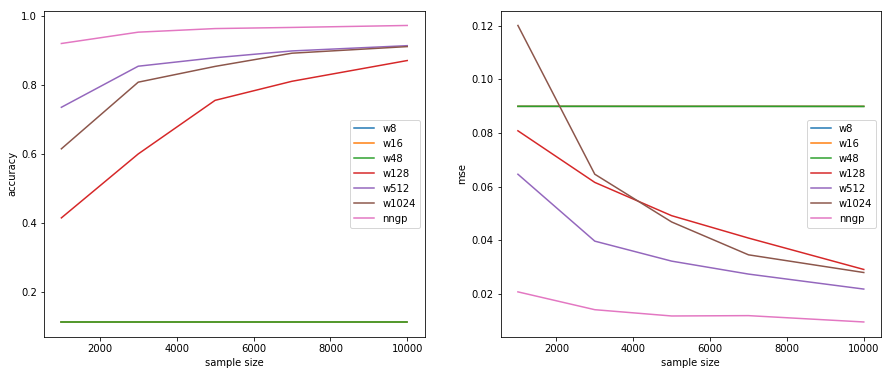

In [11]:
plt.figure(figsize = (15, 6))

plt.subplot(121)

for j, nn_width in enumerate(nn_widths):
    plt.plot(sample_sizes, nn_results[:, j, 0], label='w%d' % nn_width)
plt.plot(sample_sizes, nngp_results[:, 0], label='nngp')
plt.xlabel('sample size')
plt.legend()
_ = plt.ylabel('accuracy')

plt.subplot(122)

for j, nn_width in enumerate(nn_widths):
    plt.plot(sample_sizes, nn_results[:, j, 1], label='w%d' % nn_width)
plt.plot(sample_sizes, nngp_results[:, 1], label='nngp')
plt.xlabel('sample size')
plt.legend()
_ = plt.ylabel('mse')